# Guppies data processing with Ecodylic Behavior


Data, to calculate:

Index(['Trial', 'FishID', , 'time', 'frame', 'ANGLE', 'x',
       'y', 'focal', 

FFGROUPS:
'group_size', 'event', 'group_membership'

1) ffgroups-metrics
    CALCULATE - AFTER FFGROUPS - PER FRAME
    'distance_from_centroid', 'xrot_to_centroid', 'yrot_to_centroid', 'dev_speed_to_mean'
    CALCULATE - AFTER FFGROUPS - SUMMARY
    'fractime_norm2', 'avg_duration_frame', 'med_duration_frame', 'ftime_periphery', 'ftime_periphery_norm', 


2) speed-angvel
CALCULATE - SIMPLE:
speed, 'angularspeed' 'speed-std', 'RMS_delta_angle' (maybe not needed - angular speed is used)

3) nearestneighbor
CALCULATE - DIST.  saves:  nn_id, nn_delta_x, nn_delta_y, nn_dist, nn_(diff in ego centric coords?)
'nndist', 'nn_dist-std'


?? or not needed:
'frame_id_count', 'frame_gsize_sum', 'frame_id_sum',
'norm_ftime2'
'ftime_front_norm',  'ftime_front'  
       'fractime_norm2_trialnorm'
       'speed_trialnormall'

4) social forces
   ** NEEDS nndist  (feature requires inputset, with tracks and nearest)



In [1]:
import pandas as pd
filename = '/Volumes/JD-SSD/guppies/guppies/dataset/tracks/control_treatment__t59_d5.parquet'
pd.read_parquet(filename)

,frame,time,id,group,sequence,X#wcentroid,Y#wcentroid,ANGLE,SPEED#wcentroid,ACCELERATION#wcentroid,border_distance_cm,midline_length,x,y,Focal_fish,bad_frame
0,108001,3599.909424,0,control_treatment,t59_d5,8.703287,23.131819,-2.570283,1.326016,45.204636,8.736189,17.571571,8.622351,22.916702,0,0
1,108001,3599.909424,1,control_treatment,t59_d5,8.554715,22.607578,2.527856,2.219128,17.820446,8.586458,11.594145,8.475160,22.397339,0,0
2,108001,3599.909424,2,control_treatment,t59_d5,14.362971,13.778959,2.239858,2.227515,17.878916,13.676469,40.618824,14.229402,13.650820,0,0
3,108001,3599.909424,3,control_treatment,t59_d5,7.470642,27.537029,0.340293,0.490705,19.561220,7.314008,46.053547,7.401168,27.280945,0,0
4,108001,3599.909424,4,control_treatment,t59_d5,8.175490,20.321123,-0.215024,0.971326,11.904131,8.020432,44.742889,8.099462,20.132145,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1828613,339985,11332.468750,3,control_treatment,t59_d5,63.349174,9.468217,2.828627,1.011021,4.859296,9.431363,45.866978,62.760052,9.380167,0,0
1828614,339985,11332.468750,4,control_treatment,t59_d5,65.453857,7.264638,3.132723,1.425061,12.423551,7.257699,47.866180,64.845161,7.197080,0,0
1828615,339985,11332.468750,5,control_treatment,t59_d5,NaN,NaN,NaN,NaN,NaN,5.609266,NaN,70.451675,5.564590,0,0
1828616,339985,11332.468750,6,control_treatment,t59_d5,68.578171,4.781428,2.396162,0.523825,23.926695,4.779736,26.149790,67.940422,4.736963,0,0


In [3]:
import pandas as pd
filename = '/Volumes/JD-SSD/guppies/guppies/dataframes/guppy_8_t21_d1_processing3.pkl'
df = pd.read_pickle(filename)
df.columns

Index(['FishID', 'event', 'time', 'Trial', 'frame', 'X#wcentroid',
       'Y#wcentroid', 'ANGLE', 'border_distance_cm', 'SPEED#wcentroid',
       'ACCELERATION#wcentroid', 'midline_length', 'x', 'y', 'Focal_fish',
       'trex_tracking_error', 'time_diff', 'x_diff', 'y_diff', 'speed',
       'acceleration', 'heading', 'dir_x', 'dir_y', 'dirx_angle', 'diry_angle',
       'midlen', 'BL', 'dt', 'skipped_frames', 'speed_original',
       'filtered_speed_cat', 'bad_frame', 'all_errors', 'group_membership',
       'group_size', 'delta_x', 'delta_y', 'step_distance',
       'cumulative_distance', 'turning_rate', 'turning_rate_abs', 'centroid_x',
       'centroid_y', 'centroid_heading', 'centroid_dirx', 'centroid_diry',
       'centroid_speed', 'polarization_group', 'polarization_group_trans',
       'distance_from_centroid', 'angle_from_centroid', 'xrot_to_centroid',
       'yrot_to_centroid', 'norm_speed_to_median', 'norm_speed_to_mean',
       'dev_speed_to_mean', 'dev_speed_to_median', 'de

In [6]:
df['group_membership'].unique()

array([2., 0., 3., 1., 4., 5., 6., 7.])

# Load dataset and convert to standard format

In [328]:
import importlib
from pathlib import Path
from IPython.display import display

import numpy as np
import pandas as pd
from behavior import dataset as ds
import behavior.features as features
import behavior.analysis as analysis

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice")

importlib.reload(ds)
importlib.reload(features)
importlib.reload(analysis)


<module 'behavior.analysis' from '/Users/jacob/Documents/GitHub/EcodylicScience/behavior/src/behavior/analysis.py'>

## Load

In [329]:
import re
import json
from pathlib import Path

import pandas as pd
import yaml
from behavior.helpers import to_safe_name

# ---------------------------------------------------------------------
# 1) Define dataset config for "guppies"
# ---------------------------------------------------------------------
DATASET_CONFIGS = {
    "guppies": {
        "manifest": "/Volumes/JD-SSD/guppies/guppies/dataset/dataset.yaml",
        "manifest_params": {
            "name": "guppies",
            "base_dir": "/Volumes/JD-SSD/guppies/guppies/dataset/",
            "version": "0.1.0",
            "index_format": "group/sequence",
        },
        # optional metadata used by your own tooling
        "groups": None,
        "label_kind": None,
        "media_index": None,
        "tracks_index": {
            "search_dirs": [
                "/Volumes/JD-SSD/guppies/guppies/dataframes",
                "/Volumes/JD-SSD/guppies/guppies/dataframes_control",
            ],
            "patterns": "*processing3.pkl",
            # here we are doing a one-off manual conversion, so src_format
            # is just informative; the code below doesn't use it.
            "src_format": "guppies_pkl",
            "multi_sequences_per_file": False,
        },
        "convert_tracks": {
            "merge_per_sequence": False,
        },
    },
}

ACTIVE_DATASET = "guppies"
CFG = DATASET_CONFIGS[ACTIVE_DATASET]
print(f"Using dataset '{ACTIVE_DATASET}'")


Using dataset 'guppies'


In [330]:
manifest_path = Path(CFG["manifest"])
if not manifest_path.exists():
    manifest_args = CFG.get("manifest_params")
    if not manifest_args:
        raise FileNotFoundError(f"Manifest {manifest_path} is missing and no creation params were provided.")
    created = ds.new_dataset_manifest(**manifest_args)
    print(f"Created manifest at {created}")

dataset = ds.Dataset(str(manifest_path))
dataset.load()
print(f"Loaded dataset '{dataset.name}' -> {manifest_path}")


Loaded dataset 'guppies' -> /Volumes/JD-SSD/guppies/guppies/dataset/dataset.yaml


## Convert tracks

In [4]:


# ---------------------------------------------------------------------
# 3) Helpers for conversion
# ---------------------------------------------------------------------
def get_sequence(src_path: Path) -> str:
    """
    Extract 't21_d1' from 'guppy_8_t21_d1_processing3.pkl'.
    Adjust the regex if your naming differs.
    """
    stem = src_path.stem  # e.g., "guppy_8_t21_d1_processing3"
    m = re.search(r"_t(\d+_d\d+)", stem)
    if not m:
        # fallback: whole stem
        return stem
    return f"t{m.group(1)}"  # "t21_d1"


def iter_group_files():
    """
    Yield (group_name, list_of_files) for each experimental group.
    Adjust group names as you like.
    """

    root = Path("/Volumes/JD-SSD/guppies/guppies/dataframes")
    pattern = re.compile(r"_d1(_|$)")
    
    files_exp_baseline = sorted(
        p for p in root.glob("*_processing3.pkl")
        if pattern.search(p.stem)
    )
    files_exp_treatment = sorted(
        p for p in root.glob("*_processing3.pkl")
        if not pattern.search(p.stem)
    )
    
    root = Path("/Volumes/JD-SSD/guppies/guppies/dataframes_control/")
    files_control_baseline = sorted(
        p for p in root.glob("*_processing3.pkl")
        if pattern.search(p.stem)
    )
    files_control_treatment = sorted(
        p for p in root.glob("*_processing3.pkl")
        if not pattern.search(p.stem)
    )    

    yield "exp_baseline", files_exp_baseline
    yield "exp_treatment", files_exp_treatment
    yield "control_baseline", files_control_baseline
    yield "control_treatment", files_control_treatment

# ---------------------------------------------------------------------
# 4) Convert PKL -> tracks parquet + save per-ID focal labels
# ---------------------------------------------------------------------
tracks_root = dataset.get_root("tracks")
tracks_root.mkdir(parents=True, exist_ok=True)
print("Tracks root:", tracks_root)

for group, file_list in iter_group_files():
    print(f"\n=== Converting group '{group}' ({len(file_list)} files) ===")
    for src in file_list:
        src = Path(src)
        sequence = get_sequence(src)

        out_path = tracks_root / f"{group}__{sequence}.parquet"

        # ---- load source PKL ---------------------------------------------------
        df = pd.read_pickle(src)

        # ---- normalize to standard tracks schema ------------------------------
        trex_df = pd.DataFrame({
            "frame": df["frame"].astype("int32"),
            "time": df["time"].astype("float32", copy=False),
            "id": df["FishID"].astype("int32"),
            "group": group,
            "sequence": sequence,
            # main kinematic fields (rename to your canonical names if needed)
            "X#wcentroid": df["X#wcentroid"].astype("float32", copy=False),
            "Y#wcentroid": df["Y#wcentroid"].astype("float32", copy=False),
            "ANGLE": df["ANGLE"].astype("float32", copy=False),
            "SPEED#wcentroid": df["SPEED#wcentroid"].astype("float32", copy=False),
            "ACCELERATION#wcentroid": df["ACCELERATION#wcentroid"].astype("float32", copy=False),
            # extra numeric features you might want:
            "border_distance_cm": df["border_distance_cm"].astype("float32", copy=False),
            "midline_length": df["midline_length"].astype("float32", copy=False),
            "x": df["x"].astype("float32", copy=False),
            "y": df["y"].astype("float32", copy=False),
            # flags / errors / focal info:
            "Focal_fish": df["Focal_fish"].astype("int8"),
            "bad_frame": df["bad_frame"].astype("int8"),
        })

        trex_df = trex_df.sort_values(["frame", "id"]).reset_index(drop=True)

        out_path.parent.mkdir(parents=True, exist_ok=True)
        trex_df.to_parquet(out_path, index=False)
        print("Saved tracks ->", out_path)

        # ---- per-ID focal labels (id_tags) ------------------------------------
        focal_per_id = (
            df.groupby("FishID")["Focal_fish"]
              .max()      # assume 0/1 flag; if not, adjust
              .astype(bool)
              .to_dict()
        )

        per_id_labels = {
            int(fid): {"focal": bool(is_focal)}
            for fid, is_focal in focal_per_id.items()
        }

        # This assumes you have dataset.save_id_labels implemented.
        dataset.save_id_labels(
            kind="id_tags",
            group=group,
            sequence=sequence,
            per_id_labels=per_id_labels,
            metadata={"source_file": src.name},
            overwrite=True,
        )
        print(f"Saved focal tags for sequence '{sequence}'")

# ---------------------------------------------------------------------
# 5) Build tracks/index.csv so Dataset can discover the sequences
# ---------------------------------------------------------------------
index_rows = []
for p in sorted(tracks_root.glob("*.parquet")):
    stem = p.stem  # "group__sequence"
    if "__" in stem:
        group, sequence = stem.split("__", 1)
    else:
        group, sequence = "", stem

    # read minimal info to populate index
    df = pd.read_parquet(p, columns=["frame"])
    n_frames = len(df)
    first_frame = int(df["frame"].min())
    last_frame = int(df["frame"].max())

    index_rows.append({
        "group": group,
        "sequence": sequence,
        "sequence_safe": to_safe_name(sequence),
        "abs_path": str(p),
        "n_frames": n_frames,
        "first_frame": first_frame,
        "last_frame": last_frame,
    })

idx_df = pd.DataFrame(index_rows)
idx_path = tracks_root / "index.csv"
idx_df.to_csv(idx_path, index=False)
print("\nWrote tracks index ->", idx_path)
print("Indexed", len(idx_df), "tracks files.")

Tracks root: /Volumes/JD-SSD/guppies/guppies/dataset/tracks

=== Converting group 'exp_baseline' (24 files) ===
Saved tracks -> /Volumes/JD-SSD/guppies/guppies/dataset/tracks/exp_baseline__t21_d1.parquet
Saved focal tags for sequence 't21_d1'
Saved tracks -> /Volumes/JD-SSD/guppies/guppies/dataset/tracks/exp_baseline__t22_d1.parquet
Saved focal tags for sequence 't22_d1'
Saved tracks -> /Volumes/JD-SSD/guppies/guppies/dataset/tracks/exp_baseline__t23_d1.parquet
Saved focal tags for sequence 't23_d1'
Saved tracks -> /Volumes/JD-SSD/guppies/guppies/dataset/tracks/exp_baseline__t24_d1.parquet
Saved focal tags for sequence 't24_d1'
Saved tracks -> /Volumes/JD-SSD/guppies/guppies/dataset/tracks/exp_baseline__t25_d1.parquet
Saved focal tags for sequence 't25_d1'
Saved tracks -> /Volumes/JD-SSD/guppies/guppies/dataset/tracks/exp_baseline__t27_d1.parquet
Saved focal tags for sequence 't27_d1'
Saved tracks -> /Volumes/JD-SSD/guppies/guppies/dataset/tracks/exp_baseline__t36_d1.parquet
Saved foca

# FFGroups dev

In [14]:
df = pd.read_parquet('/Volumes/JD-SSD/guppies/guppies/dataset/tracks/exp_baseline__t21_d1.parquet')

In [20]:
df = df[df['frame']<128001]
self = ffgroups.FFGroups({"distance_cutoff": 20.32, "window_size": 30, "min_event_duration": 60})

In [ ]:
       if df is None or df.empty:
            return pd.DataFrame()

        p = self.params
        id_col = p["id_col"]
        x_col, y_col = p["x_col"], p["y_col"]
        frame_col = p["frame_col"]
        time_col = p.get("time_col")
        group_col, seq_col = p["group_col"], p["seq_col"]
        distance_cutoff = float(p["distance_cutoff"])
        win = max(1, int(p["window_size"]))
        min_event = int(p["min_event_duration"])

        # Basic ordering and bookkeeping
        order_cols = [c for c in (frame_col, time_col) if c in df.columns]
        if order_cols:
            df = df.sort_values(order_cols).reset_index(drop=True)
        group_val = str(df[group_col].iloc[0]) if group_col in df.columns else ""
        seq_val = str(df[seq_col].iloc[0]) if seq_col in df.columns else ""

        frames = np.asarray(sorted(df[frame_col].dropna().unique()), dtype=int)
        ids = np.asarray(sorted(df[id_col].dropna().unique()))
        if frames.size == 0 or ids.size == 0:
            return pd.DataFrame()

        id_to_idx = {v: i for i, v in enumerate(ids)}
        T, N = len(frames), len(ids)

        # Build pairwise distance tensor (T, N, N) with nan for missing individuals
        pairwise = np.full((T, N, N), np.nan, dtype=np.float32)
        frame_to_pos = {f: i for i, f in enumerate(frames)}
        all_ids_set = set(ids.tolist())

        for f, sub in df.groupby(frame_col):
            if f not in frame_to_pos:
                continue
            t_idx = frame_to_pos[f]
            coords = sub[[id_col, x_col, y_col]].dropna(subset=[id_col, x_col, y_col])
            if coords.empty:
                continue
            coords = coords.drop_duplicates(subset=[id_col], keep="last").set_index(id_col)
            ids_present = coords.index.to_numpy()
            xy = coords[[x_col, y_col]].to_numpy(dtype=np.float32, copy=False)

            if len(ids_present) == N and set(ids_present) == all_ids_set:
                # Fast path: all IDs present; reorder positions to global id order and assign directly
                order = np.argsort([id_to_idx.get(i, N + idx) for idx, i in enumerate(ids_present)])
                xy_full = xy[order]
                dmat = cdist(xy_full, xy_full).astype(np.float32)
                np.fill_diagonal(dmat, np.nan)
                pairwise[t_idx] = dmat
            else:
                # Distance matrix for present ids only
                dmat = cdist(xy, xy).astype(np.float32)
                np.fill_diagonal(dmat, np.nan)

                # Map into full (N x N) slots
                global_idx = []
                local_idx = []
                for local_i, id_i in enumerate(ids_present):
                    gi = id_to_idx.get(id_i)
                    if gi is None:
                        continue
                    global_idx.append(gi)
                    local_idx.append(local_i)
                if not global_idx:
                    continue
                global_idx = np.asarray(global_idx, dtype=int)
                local_idx = np.asarray(local_idx, dtype=int)
                pairwise[t_idx] = np.nan  # reset row in case of partial fill
                pairwise[t_idx][np.ix_(global_idx, global_idx)] = dmat[np.ix_(local_idx, local_idx)]

        # Smooth along time axis with centered window
        if win > 1 and T > 0:
            pad = win // 2
            pad_block = np.full((pad, N, N), np.nan, dtype=np.float32)
            padded = np.concatenate([pad_block, pairwise, pad_block], axis=0)
            if padded.shape[0] >= win:
                # windows shape: (T, N, N, win) when sliding along time axis only
                windows = sliding_window_view(padded, window_shape=win, axis=0)
                pairwise_smooth = np.nanmean(windows, axis=-1)
            else:
                pairwise_smooth = pairwise
        else:
            pairwise_smooth = pairwise

        # Prepare input for dp.calculate_gmembership: (T, N, N-1)
        mask = ~np.eye(N, dtype=bool)
        pwdf = pairwise_smooth[:, mask].reshape(T, N, N - 1)
        groupmembership = _calculate_gmembership(pwdf, nparticles=N, numsteps=T, threshold=distance_cutoff)

        # Group sizes per frame/id
        gm = groupmembership.astype(np.int64, copy=False)
        if gm.size:
            max_label = int(gm.max(initial=0))
            counts = np.zeros((T, max_label + 1), dtype=np.int32)
            np.add.at(counts, (np.arange(T)[:, None], gm), 1)
            group_sizes = counts[np.arange(T)[:, None], gm]
        else:
            group_sizes = np.zeros_like(gm, dtype=np.int32)

        # Build base output
        out = pd.DataFrame({
            frame_col: np.repeat(frames, N),
            id_col: np.tile(ids, T),
            "group_membership": groupmembership.reshape(-1),
            "group_size": group_sizes.reshape(-1),
        })

        if time_col and time_col in df.columns:
            time_map = df.groupby(frame_col)[time_col].first()
            out[time_col] = out[frame_col].map(time_map)
        if seq_col in df.columns:
            out[seq_col] = seq_val
        else:
            out[seq_col] = seq_val
        if group_col in df.columns:
            out[group_col] = group_val
        else:
            out[group_col] = group_val

        # Event detection (dp.get_events_info expects 'FishID')
        event_input = out.rename(columns={id_col: "FishID"})
        try:
            df_events, _ = _get_events_info(event_input, threshold_ev_duration=min_event)
            df_events = df_events[["frame", "FishID", "event"]]
            out = out.merge(df_events.rename(columns={"FishID": id_col, "event": "event"}),
                            how="left", on=[frame_col, id_col])
        except Exception:
            # If event detection fails, still return membership/size
            out["event"] = np.nan

        out["event"] = out["event"].fillna(-1).astype(int)
        return out

# Feature calculation:  FFGroups

In [ ]:
%%time
import importlib, feature_library.ffgroups as ffgroups
importlib.reload(ffgroups)

# 1) Run ffgroups on a subset of sequences (from tracks)
run_id = dataset.run_feature(
    ffgroups.FFGroups({"distance_cutoff": 20.32, "window_size": 31, "min_event_duration": 60}),
    input_kind="tracks",
    # groups=["exp_baseline"],    # or None for all
    sequences = dataset.list_sequences(group="exp_baseline")[0:2],
    parallel_workers = 3,
    parallel_mode = "process"
)

In [67]:
# 2) Create an inputset that holds tracks + ffgroups outputs
# run_id = "0.1-e379e8cd17"
ds.save_inputset(
    dataset,
    name="tracks+ffgroups-paper",
    inputs=[
        {"kind": "tracks"},  # raw ids/metadata  "columns": ["frame", "time", "id", "group", "sequence"]
        {"feature": "ffgroups", "run_id": run_id},                                   # this ffgroups run
    ],
    overwrite=True,
)

PosixPath('/Volumes/JD-SSD/guppies/guppies/dataset/inputsets/tracks%2Bffgroups-paper.json')

In [406]:
from behavior.dataset import _yield_inputset_frames

target_sequence = "t21_d1"
rows = []
for g, s, df in _yield_inputset_frames(
    dataset,
    inputset_name="tracks+ffgroups-paper",
    sequences=[target_sequence],
):
    rows.append(df)

merged = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
display(merged.head())


,frame,time,id,group,sequence,X#wcentroid,Y#wcentroid,ANGLE,SPEED#wcentroid,ACCELERATION#wcentroid,border_distance_cm,midline_length,x,y,Focal_fish,bad_frame,group_membership,group_size,event
0,108001,3602.594238,0,exp_baseline,t21_d1,69.203613,88.964195,-0.005224,0.234207,14.880315,31.029045,29.967735,68.560051,88.136864,0,0,0.0,3,2
1,108001,3602.594238,1,exp_baseline,t21_d1,111.893616,110.061966,1.114550,2.747268,37.429714,8.098183,31.673729,110.853043,109.038429,1,0,1.0,2,4
2,108001,3602.594238,2,exp_baseline,t21_d1,56.710899,72.049995,0.504916,2.935105,14.312032,47.984619,23.183081,56.183510,71.379959,0,0,0.0,3,2
3,108001,3602.594238,3,exp_baseline,t21_d1,106.361130,33.800343,0.102539,1.299904,15.424468,13.788536,32.029694,105.372017,33.486012,0,0,2.0,2,0
4,108001,3602.594238,4,exp_baseline,t21_d1,101.645119,35.509937,0.533460,5.504618,19.183117,18.561928,55.136238,100.699860,35.179710,0,0,2.0,2,0


# Features:  speed, nn, ff metrics

## Speed

In [118]:
import feature_library.speed_angvel as speed_angvel
importlib.reload(speed_angvel)

feat_speed = speed_angvel.SpeedAngvel({
        "step_size": 2,          # set None to skip _step outputs
    })

# 1) Speed/AngVel per-frame
run_id_speed = dataset.run_feature(feat_speed
    ,
    input_kind="tracks",
    parallel_workers=5,
    parallel_mode="process",
    sequences = dataset.list_sequences(group="exp_baseline")[0:1],                                   
)

[feature:speed-angvel] completed run_id=0.1-36a987b6dd -> /Volumes/JD-SSD/guppies/guppies/dataset/features/speed-angvel/0.1-36a987b6dd


## NN

In [58]:
%%time
import feature_library.nearestneighbor as nearestneighbor
importlib.reload(nearestneighbor)

# 2) Nearest neighbor per-frame deltas
run_id_nn = dataset.run_feature(
    nearestneighbor.NearestNeighbor(),
    input_kind="tracks",
    parallel_workers=3,
    parallel_mode="process",
    groups=["exp_baseline"],    # or None for all
    sequences = dataset.list_sequences(group="exp_baseline")[0:1],
)


[feature:nearest-neighbor] completed run_id=0.1-0d9a53494a -> /Volumes/JD-SSD/guppies/guppies/dataset/features/nearest-neighbor/0.1-0d9a53494a
CPU times: user 811 ms, sys: 618 ms, total: 1.43 s
Wall time: 16.3 s


## FF metrics

In [326]:
# 2) Create an inputset that holds tracks + ffgroups outputs
# run_id = "0.1-e379e8cd17"
ds.save_inputset(
    dataset,
    name="tracks+ffgroups-paper",
    inputs=[
        {"kind": "tracks"},  # raw ids/metadata  "columns": ["frame", "time", "id", "group", "sequence"]
        {"feature": "ffgroups", "run_id": run_id},                                   # this ffgroups run
    ],
    overwrite=True,
)

PosixPath('/Volumes/JD-SSD/guppies/guppies/dataset/inputsets/tracks%2Bffgroups-paper.json')

In [463]:
%%time
import importlib, feature_library.ffgroups_metrics as ffgroups_metrics
importlib.reload(ffgroups_metrics)

# pr = cProfile.Profile()
# pr.enable()

run_id_ffgmetrics = dataset.run_feature(
    ffgroups_metrics.FFGroupsMetrics({
        # "x_col": "x",
        # "y_col": "y",
        "heading_col": "ANGLE",
        "speed_col": "SPEED#wcentroid",
        # "id_col": "id",
        # "group_col": "event",            # use event as the per-frame grouping
    }),
    input_kind="inputset",
    input_feature="tracks+ffgroups-paper",     # name of the inputset
    parallel_workers=1,
    parallel_mode="process",
    sequences=dataset.list_sequences(group="exp_baseline")[0:1],
    overwrite=True
)

# pr.disable()
# pstats.Stats(pr).sort_stats("cumtime").print_stats(30)

[feature:ffgroups-metrics__from__tracks+ffgroups-paper] completed run_id=0.1-daafbd59c1 -> /Volumes/JD-SSD/guppies/guppies/dataset/features/ffgroups-metrics__from__tracks+ffgroups-paper/0.1-daafbd59c1
CPU times: user 1min 21s, sys: 728 ms, total: 1min 22s
Wall time: 1min 22s


## Dev - testing

In [460]:
import importlib, feature_library.ffgroups_metrics as ffgroups_metrics
importlib.reload(ffgroups_metrics)

# Take one event from the merged dataframe
event_id = merged["event"].iloc[10]
event_df = merged[merged["event"] <= event_id].copy()

feat = ffgroups_metrics.FFGroupsMetrics({
    "heading_col": "ANGLE",
    "speed_col": "SPEED#wcentroid",
    "group_col": "event",   # group per frame within event
})

# Build group_keys as transform would
order_col = feat._order_col(event_df)
event_df = event_df.sort_values(order_col)
group_keys = ["event", "frame"]
per_frame = feat._compute_per_frame(event_df, feat.params, group_keys)
summary = feat._compute_summary(per_frame, feat.params)


# print(per_frame[["frame", "distance_from_centroid", "group_size"]].head())
# print(summary[["id", "group_size", "ftime_periphery", "ftime_periphery_norm"]].head())
summary

,id,group_size,fractime_norm2,avg_duration_frame,med_duration_frame,ftime_periphery,ftime_periphery_norm,sequence,event
0,0,1,0.069089,33.541667,28.0,0.426667,0.426667,t21_d1,0
1,0,2,0.139611,354.289474,32.5,0.379032,0.758065,t21_d1,0
2,0,3,0.156295,230.961538,27.5,0.201703,0.605108,t21_d1,0
3,0,4,0.203582,223.507692,29.0,0.174962,0.699849,t21_d1,0
4,0,5,0.152405,55.120000,28.5,0.151780,0.758899,t21_d1,0
...,...,...,...,...,...,...,...,...,...
59,7,4,0.153799,135.250000,28.0,0.232355,0.929421,t21_d1,0
60,7,5,0.161483,71.625000,31.5,0.231873,1.159366,t21_d1,0
61,7,6,0.112941,88.393939,28.0,0.160907,0.965443,t21_d1,0
62,7,7,0.092328,31.541667,31.5,0.348745,2.441215,t21_d1,0


In [ ]:
prev = pd.read_pickle('/Volumes/JD-SSD/guppies/guppies/dataframes/guppy_8_t21_d1_processing3.pkl')

In [570]:
import importlib, feature_library.ffgroups_metrics as ffgroups_metrics
importlib.reload(ffgroups_metrics)

# Pick one event from prev
# event_id = prev["event"].iloc[10]
# event_df = prev[prev["event"] == event_id].copy()
event_df = prev

feat = ffgroups_metrics.FFGroupsMetrics({
    "id_col": "FishID",
    "seq_col": "Trial",
    "group_col": "event",          # group per frame within event
    "heading_col": "ANGLE",
    "speed_col": "speed",
    "x_col": "x",
    "y_col": "y",
})

# Build group_keys as transform would
order_col = feat._order_col(event_df)
event_df = event_df.sort_values(order_col)
group_keys = ["event", "frame"]

per_frame = feat._compute_per_frame(event_df, feat.params, group_keys)
summary = feat._compute_summary(per_frame, feat.params)

summary.head()


,FishID,group_size,fractime_norm2,avg_duration_frame,med_duration_frame,ftime_periphery,ftime_periphery_norm,Trial,event
0,0.0,1.0,0.200864,256.491228,135.0,1.000000,1.000000,t21_h,2075
1,0.0,2.0,0.251158,266.193237,148.0,0.616991,1.233982,t21_h,2075
2,0.0,3.0,0.140106,138.295455,85.5,0.337240,1.011720,t21_h,2075
3,0.0,4.0,0.134677,149.427136,83.0,0.204219,0.816877,t21_h,2075
4,0.0,5.0,0.108257,136.459302,71.5,0.164288,0.821439,t21_h,2075


In [ ]:
## compare prev and per_frame, since they have the same things

In [572]:
import pandas as pd

# Align on FishID + frame, then correlate numeric columns
merge_keys = ["FishID", "frame"]
aligned = prev.merge(per_frame, on=merge_keys, suffixes=("_old", "_new"))

aligned = aligned[aligned['group_size_new']>2]

corrs = []
for col in aligned.columns:
    if not col.endswith("_old"):
        continue
    base = col[:-4]
    col_new = f"{base}_new"
    if col_new not in aligned.columns:
        continue
    # only numeric columns
    if not pd.api.types.is_numeric_dtype(aligned[col]) or not pd.api.types.is_numeric_dtype(aligned[col_new]):
        continue
    sub = aligned[[col, col_new]].apply(pd.to_numeric, errors="coerce").dropna()
    if sub.empty:
        continue
    corrs.append((base, sub[col].corr(sub[col_new])))

corr_df = pd.DataFrame(corrs, columns=["column", "pearson_corr"]).sort_values("pearson_corr")
print(corr_df)


                    column  pearson_corr
47  distance_from_centroid           1.0
49        xrot_to_centroid           1.0
50        yrot_to_centroid           1.0
53       dev_speed_to_mean           1.0
24                      BL           1.0
..                     ...           ...
38        turning_rate_abs           1.0
40              centroid_y           1.0
42           centroid_dirx           1.0
72         ev_duration_sec           1.0
70     percentage_excluded           NaN

[73 rows x 2 columns]


/Users/jacob/miniforge3/envs/beesbook/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


In [542]:
## compare just a single event

event_id = prev["event"].iloc[10]
dfsel_prev = prev[prev["event"] == event_id]
dfsel_pf = per_frame[per_frame["event"] == event_id]

merge_keys = ["FishID", "frame"]
aligned = dfsel_prev.merge(dfsel_pf, on=merge_keys, suffixes=("_old", "_new"))

corrs = []
for col in aligned.columns:
    if not col.endswith("_old"):
        continue
    base = col[:-4]
    col_new = f"{base}_new"
    if col_new not in aligned.columns:
        continue
    # Only correlate numeric columns
    if not pd.api.types.is_numeric_dtype(aligned[col]) or not pd.api.types.is_numeric_dtype(aligned[col_new]):
        continue
    sub = aligned[[col, col_new]].apply(pd.to_numeric, errors="coerce").dropna()
    if sub.empty:
        continue
    corrs.append((base, sub[col].corr(sub[col_new])))

corr_df = pd.DataFrame(corrs, columns=["column", "pearson_corr"]).sort_values("pearson_corr")
print(corr_df)


                    column  pearson_corr
43           centroid_diry           1.0
2              X#wcentroid           1.0
50          delta_angle_32           1.0
5       border_distance_cm           1.0
36     cumulative_distance           1.0
7   ACCELERATION#wcentroid           1.0
9                        x           1.0
27          speed_original           1.0
16                   speed           1.0
41        centroid_heading           1.0
39              centroid_x           1.0
46           delta_angle_4           1.0
44          centroid_speed           1.0
35           step_distance           1.0
37            turning_rate           1.0
38        turning_rate_abs           1.0
1                     time           1.0
42           centroid_dirx           1.0
47       delta_angle_4_abs           1.0
48          delta_angle_16           1.0
49      delta_angle_16_abs           1.0
40              centroid_y           1.0
34                 delta_y           1.0
25              

/Users/jacob/miniforge3/envs/beesbook/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jacob/miniforge3/envs/beesbook/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jacob/miniforge3/envs/beesbook/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jacob/miniforge3/envs/beesbook/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jacob/miniforge3/envs/beesbook/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jacob/miniforge3/envs/beesbook/lib/python3.12/site-packages/numpy/lib/_function_base_imp

# Compare calculated metrics here with saved ones

In [466]:
metrics = pd.read_parquet('/Volumes/JD-SSD/guppies/guppies/dataset/features/ffgroups-metrics__from__tracks+ffgroups-paper/0.1-daafbd59c1/exp_baseline__t21_d1.parquet')

In [467]:
dfsel_h = pd.read_parquet('/Users/jacob/Seafile/Guppy simulation codes/saved_results/dfsel_h.parquet')


In [481]:
metrics_prev = dfsel_h[dfsel_h['Trial']=='t21_h']
# metrics_prev = summary
metrics_prev = metrics_prev.rename(columns={'FishID':'id'})

In [478]:
cols = ['fractime_norm2', 'avg_duration_frame','ftime_periphery']
keys = ['id', 'group_size']

# select and rename new metrics
metrics_new = metrics[keys + cols].copy()
metrics_new = metrics_prev.copy()
metrics_new = metrics_new.rename(columns={col: f"{col}_new" for col in cols})

# select old metrics
metrics_old = metrics_prev[keys + cols].copy()
metrics_old = metrics_old.rename(columns={col: f"{col}_old" for col in cols})

# merge for comparison
metrics_compare = metrics_new.merge(metrics_old, on=keys, how='outer')

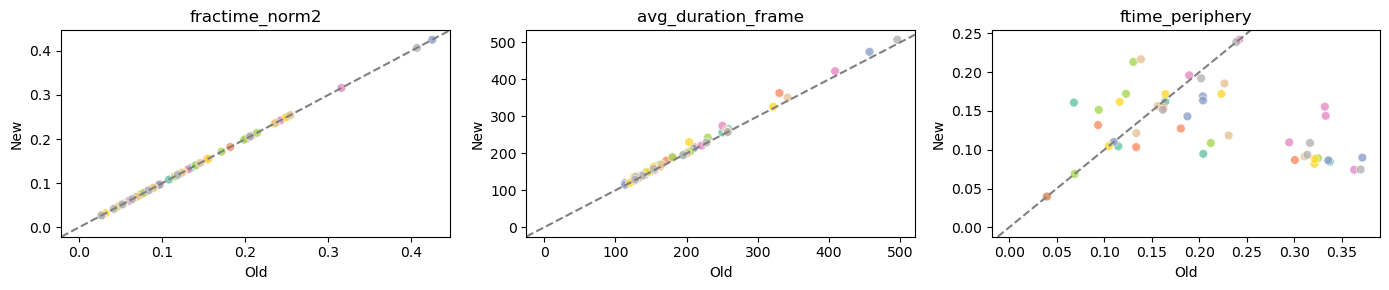

In [491]:
import seaborn as sns
import matplotlib.pyplot as plt

color_by = "id"         # or "group_size"
palette = sns.color_palette("Set2")

f, ax = plt.subplots(1, 3, figsize=(14, 3))

for a, col in zip(ax, cols):
    if col == "ftime_periphery":
        dfsel = metrics_compare[metrics_compare["group_size"] >= 3]
    else:
        dfsel = metrics_compare

    hue_col = "id" if color_by == "id" else "group_size"

    sns.scatterplot(
        data=dfsel,
        x=f"{col}_old",
        y=f"{col}_new",
        hue=hue_col,
        palette=palette,
        ax=a,
        s=40,
        alpha=0.8,
        legend=False,
    )
    a.set_title(col)
    a.set_xlabel("Old")
    a.set_ylabel("New")
    a.axline((0, 0), slope=1, color="gray", linestyle="--")  # identity line

plt.tight_layout()
plt.show()


## Compare ffgroups identification

In [69]:
merged.head()

,frame,time_x,id,group,sequence,X#wcentroid,Y#wcentroid,ANGLE,SPEED#wcentroid,ACCELERATION#wcentroid,border_distance_cm,midline_length,x,y,Focal_fish,bad_frame,group_membership,group_size,time_y,event
0,108001,3602.594238,0,exp_baseline,t21_d1,69.203613,88.964195,-0.005224,0.234207,14.880315,31.029045,29.967735,68.560051,88.136864,0,0,0.0,3,3602.594238,2
1,108001,3602.594238,1,exp_baseline,t21_d1,111.893616,110.061966,1.114550,2.747268,37.429714,8.098183,31.673729,110.853043,109.038429,1,0,1.0,2,3602.594238,4
2,108001,3602.594238,2,exp_baseline,t21_d1,56.710899,72.049995,0.504916,2.935105,14.312032,47.984619,23.183081,56.183510,71.379959,0,0,0.0,3,3602.594238,2
3,108001,3602.594238,3,exp_baseline,t21_d1,106.361130,33.800343,0.102539,1.299904,15.424468,13.788536,32.029694,105.372017,33.486012,0,0,2.0,2,3602.594238,0
4,108001,3602.594238,4,exp_baseline,t21_d1,101.645119,35.509937,0.533460,5.504618,19.183117,18.561928,55.136238,100.699860,35.179710,0,0,2.0,2,3602.594238,0


In [70]:
prev = pd.read_pickle('/Volumes/JD-SSD/guppies/guppies/dataframes/guppy_8_t21_d1_processing3.pkl')

In [71]:
frames = prev['frame'].unique()

In [75]:
i = 100
diff = []
for i in range(2000):
    sel1 = merged[merged['frame']==frames[i]]
    sel2 = prev[prev['frame']==frames[i]]
    v1 = sel1.sort_values(by='id')['group_size'].values
    v2 = sel2.sort_values(by='FishID')['group_size'].values
    diff.append(np.mean(v1-v2))

(array([1.615e+03, 2.900e+01, 0.000e+00, 9.300e+01, 0.000e+00, 1.000e+00,
        0.000e+00, 2.320e+02, 1.500e+01, 1.500e+01]),
 array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ]),
 <BarContainer object of 10 artists>)

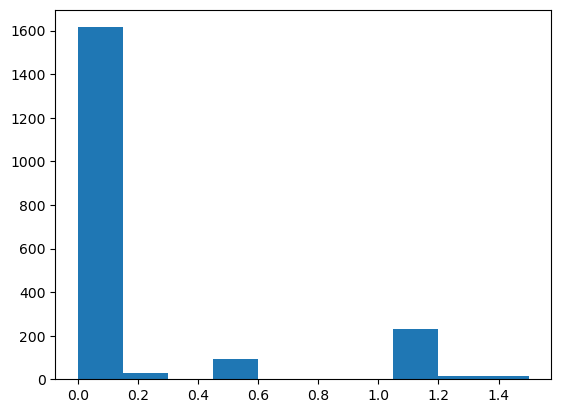

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.hist(diff)

# Conclusion:
The fision-fusion group assignment seems ok.  for a few frames, its exactly the same.  probably the speed smoothing is making the differences (would need to 